In [6]:
import math
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import rebound as rb

In [7]:
"""Intro to Rebound"""

'Intro to Rebound'

In [8]:
"""Question 2"""

sim = rb.Simulation()

sim.move_to_com()
sim.integrator = "whfast"

sim.add(m=1, hash="Binary 1")
sim.add(m=1, a=1, e= 0.1, hash="Binary 2", f=np.random.rand()*2*np.pi)
sim.add(a=2.5, e= 0.4, hash="Test Planet", f=np.random.rand()*2*np.pi)

spec_int = np.pi # half of one full orbit
sim.initSimulationArchive("Section2Q2.bin", interval = spec_int)

N_orbit = 6*np.pi #3 full orbits

sim.integrate(N_orbit, exact_finish_time=0) #setting flag to integrate up to timestep nearest to endtime
sim.dt = 1e-3

sim.exit_max_distance = 4*1

In [20]:
print(sim.particles[1].a // 1 == 1)

True


In [35]:
sim.particles[1].P

4.442882938158615

In [4]:
sim.status()
# help(rb.Simulation.initSimulationArchive)

---------------------------------
REBOUND version:     	3.5.13
REBOUND built on:    	Apr 23 2018 14:26:51
Number of particles: 	3
Selected integrator: 	whfast
Simulation time:     	1.8850000000001419e+01
Current timestep:    	0.001000
---------------------------------
<rebound.Particle object, m=1.0 x=8.626981521532466 y=10.995866996961086 z=0.0 vx=1.0938070517592002 vy=0.2508569432862644 vz=0.0>
<rebound.Particle object, m=1.0 x=9.02754862761307 y=11.857225369873808 z=0.0 vx=-0.1949872316796457 vy=0.9923331564756852 vz=0.0>
<rebound.Particle object, m=0.0 x=-1.9968257015920319 y=17.066343017721074 z=0.0 vx=-0.05630794504318415 vy=0.6689865040413686 vz=0.0>
---------------------------------


In [5]:
s1_archive = rb.SimulationArchive("Section2Q2.bin")

In [6]:
"""Question 3"""

sim2 = rb.Simulation()

sim2.move_to_com()
sim2.integrator = "whfast"

sim2.add(m=1, hash="Binary 1")
sim2.add(m=1, hash="Binary 2", a=1, e=0.5)
sim2.add(hash="Planet", a=4, e=0)

N2_orbit = 10*2*np.pi
sim2.dt = 1e-3

In [7]:
sim2.status()

---------------------------------
REBOUND version:     	3.5.13
REBOUND built on:    	Apr 23 2018 14:26:51
Number of particles: 	3
Selected integrator: 	whfast
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.001000
---------------------------------
<rebound.Particle object, m=1.0 x=0.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=0.0>
<rebound.Particle object, m=1.0 x=0.5 y=0.0 z=0.0 vx=0.0 vy=2.449489742783178 vz=0.0>
<rebound.Particle object, m=0.0 x=4.25 y=0.0 z=0.0 vx=0.0 vy=1.9318516525781364 vz=0.0>
---------------------------------


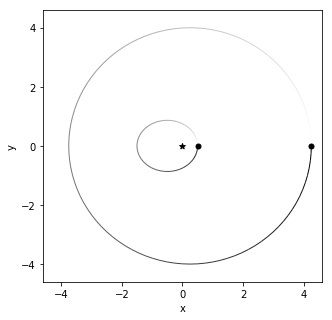

In [8]:
%matplotlib inline

fig = rb.OrbitPlot(sim2)

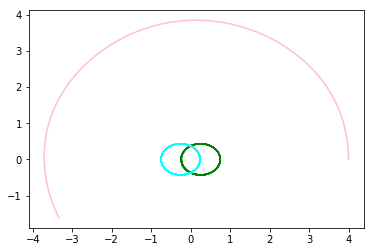

In [9]:
particles2 = sim2.particles
fig, ax = plt.subplots()
ax.plot()

#plt.xlim([-10,10])
#plt.ylim([-10,10])

torb = 6*np.pi
Noutputs = 100
times = np.linspace(0, torb, Noutputs)

b1x = []
b1y = []

b2x = []
b2y = []

px = []
py = []

sim2.move_to_com()
for i, time in enumerate(times):
    sim2.integrate(time,exact_finish_time=0)
    b1x.append(particles2[0].x)
    b1y.append(particles2[0].y)
    b2x.append(particles2[1].x)
    b2y.append(particles2[1].y)
    px.append(particles2[2].x)
    py.append(particles2[2].y)

plt.plot(b1x,b1y, color='green')
plt.plot(b2x,b2y, color='cyan')
plt.plot(px,py, color='pink')   

In [13]:
#print(particles2[0].x)

sim2.status()

---------------------------------
REBOUND version:     	3.5.13
REBOUND built on:    	Apr 23 2018 14:26:51
Number of particles: 	3
Selected integrator: 	whfast
Simulation time:     	1.8850000000001419e+01
Current timestep:    	0.001000
---------------------------------
<rebound.Particle object, m=1.0 x=0.45043090883256565 y=-0.3966996194709873 z=0.0 vx=0.5396460230574781 vy=0.20449050907872746 vz=0.0>
<rebound.Particle object, m=1.0 x=-0.45043090883256565 y=0.3966996194709873 z=0.0 vx=-0.5396460230574781 vy=-0.20449050907872746 vz=0.0>
<rebound.Particle object, m=0.0 x=-3.334454273134022 y=-1.6184443663687054 z=0.0 vx=0.3211629737155257 vy=-0.692784278538448 vz=0.0>
---------------------------------


In [15]:
print("My manually made plot compared to REBOUNDs OrbitPlot  differs as it can show me the orbit of the first binary star, which in OrbitPlot serves as the center and therefore everything orbits around that central body.")

print("If I set the ration of the semi-major axes (ap/ab) to 3, changing ap from 4 to 3, has no affect on the binary pair since the planet is a test particle planet with no mass and therfore no gravitational influence.")

My manually made plot compared to REBOUNDs OrbitPlot  differs as it can show me the orbit of the first binary star, which in OrbitPlot serves as the center and therefore everything orbits around that central body.
If I set the ration of the semi-major axes (ap/ab) to 3, changing ap from 4 to 3, has no affect on the binary pair since the planet is a test particle planet with no mass and therfore no gravitational influence.


In [16]:
"""Classic Results"""

'Classic Results'

In [ ]:
""" Question 1"""

survival_times = []

# tuples are of order (e_b, a_p) binary eccentricity 
# and planetary semi-major axis

tup1 = (0, 1)
tup2 = (0.175, 2)
tup3 = (0.35, 3)
tup4 = (0.525, 4)
tup5 = (0.7, 5)

sim3 = rb.Simulation()
sim3.move_to_com()
sim3.integrator = "whfast"
sim3.dt = 1e-3

def survival(tuple):
    reset = setupSimulation() #resetting the simulation each time the function is called
    
    N_orbit = (10e2)*2*np.pi
    sim3.add(m=1, hash="Binary 1")
    sim3.add(m=1, a=1, e= tuple[0], hash="Binary 2", f=np.random.rand()*2*np.pi)
    sim3.add(a=tuple[1], e=0, hash="Test Planet", f=np.random.rand()*2*np.pi)
    
    sim3 = integrate(N_orbit, exact_finish_time=0)
    
    if sim3.particles[1].e//tuple[0] == 1 and sim3.particles[2].a//tuple[1] == 1:
        survival_times.append([sim3.particles[2].P])
        
    # possible else statement
    return survival_times

In [5]:
help(rb.InterruptiblePool.map)
# sim3.InterruptiblePool.map(self, func that i create, interable (tuple maybe))

Help on function map in module rebound.interruptible_pool:

map(self, func, iterable, chunksize=None)
    Equivalent of ``map()`` built-in, without swallowing
    ``KeyboardInterrupt``.
    
    :param func:
        The function to apply to the items.
    
    :param iterable:
        An iterable of items that will have `func` applied to them.

